# Download Data

In [ ]:
# !gdown DATASET_SHAREABLE_LINK

In [2]:
!unzip polish_companies_bankruptcy_data.zip

Archive:  polish_companies_bankruptcy_data.zip
  inflating: 1year.arff              
  inflating: 2year.arff              
  inflating: 3year.arff              
  inflating: 4year.arff              
  inflating: 5year.arff              


In [3]:
!mkdir -p "data"
!mv *.arff  data

In [4]:
!pip install catboost

# Import

In [5]:
import os
import os.path as osp
import numpy as np
import pandas as pd
from time import time
import itertools
import joblib

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.io import arff
from collections import Counter
from imblearn.over_sampling import SMOTE

import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score

In [6]:
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Read Data

In [7]:
!ls data

1year.arff  2year.arff	3year.arff  4year.arff	5year.arff


In [8]:
def read_arff_file(path):
    data, meta = arff.loadarff(path)
    df = pd.DataFrame(data)

    return df, meta


def combine_arrf_df(data_fol):
    ll = os.listdir(data_fol)
    df_ll = []

    for name in ll:
        path = osp.join(data_fol, name)
        year = int(name[0])
        df, _ = read_arff_file(path)

        df["year"] = year
        df_ll.append(df)

    df = pd.concat(df_ll, ignore_index=True)
    df = df.drop_duplicates()

    return df



In [9]:
data_fol = "data"

df = combine_arrf_df(data_fol)
df.shape

(43004, 66)

# Data Imputation

In [10]:
msg = df.isna().sum()/df.shape[0]*100
for x in msg.sort_values(ascending=False).items():
    print(x)

('Attr37', 43.80057669054042)
('Attr21', 13.570830620407403)
('Attr27', 6.394753976374291)
('Attr60', 4.971630545995722)
('Attr45', 4.960003720584131)
('Attr24', 2.1439866058971258)
('Attr64', 1.869593526183611)
('Attr53', 1.869593526183611)
('Attr54', 1.869593526183611)
('Attr28', 1.869593526183611)
('Attr41', 1.7533252720677146)
('Attr32', 0.8510836201283601)
('Attr52', 0.6976095246953772)
('Attr47', 0.6883080643661055)
('Attr46', 0.3115989210306018)
('Attr63', 0.3092735559482839)
('Attr40', 0.3092735559482839)
('Attr4', 0.3092735559482839)
('Attr33', 0.3092735559482839)
('Attr12', 0.3092735559482839)
('Attr19', 0.2929960003720584)
('Attr20', 0.2906706352897405)
('Attr56', 0.2906706352897405)
('Attr42', 0.2906706352897405)
('Attr49', 0.2906706352897405)
('Attr43', 0.2906706352897405)
('Attr39', 0.2906706352897405)
('Attr23', 0.2906706352897405)
('Attr13', 0.2906706352897405)
('Attr31', 0.2906706352897405)
('Attr30', 0.2906706352897405)
('Attr62', 0.2906706352897405)
('Attr44', 0.2906

In [11]:
df = df.fillna(df.median())

In [12]:
df.isna().sum().sum()

np.int64(0)

# Data Preparation

In [13]:
df['class'] = df['class'].astype(int)

In [14]:
df['y'] = df['year']
df['y'][df['class']==0]=0

Counter(df['y'])

/tmp/ipython-input-974466512.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['y'][df['class']==0]=0
/tmp/ipython-input-974466512.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the

Counter({0: 40921, 5: 408, 1: 271, 2: 398, 3: 493, 4: 513})

/tmp/ipython-input-1899208705.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(br, palette='tab10')


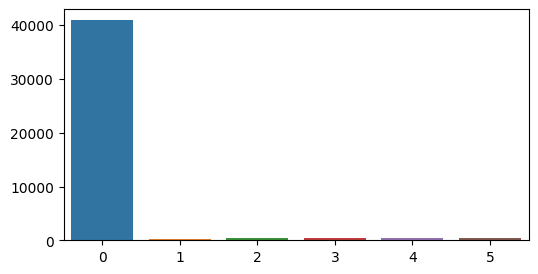

In [15]:
br = dict(Counter(df['y']))

plt.figure(figsize=(6,3))
sns.barplot(br, palette='tab10')
plt.show()

In [16]:
df = df.drop(columns=["year", "class"])

In [17]:
df.head()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,...,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,y
0,0.088238,0.55472,0.01134,1.0205,-66.5200,0.342040,0.109490,0.57752,1.0881,0.32036,...,0.080955,0.275430,0.91905,0.002024,7.2711,4.7343,142.760,2.5568,3.2597,0
1,-0.006202,0.48465,0.23298,1.5998,6.1825,0.000000,-0.006202,1.06340,1.2757,0.51535,...,-0.028591,-0.012035,1.00470,0.152220,6.0911,3.2749,111.140,3.2841,3.3700,0
2,0.130240,0.22142,0.57751,3.6082,120.0400,0.187640,0.162120,3.05900,1.1415,0.67731,...,0.123960,0.192290,0.87604,0.000000,8.7934,2.9870,71.531,5.1027,5.6188,0
3,-0.089951,0.88700,0.26927,1.5222,-55.9920,-0.073957,-0.089951,0.12740,1.2754,0.11300,...,0.418840,-0.796020,0.59074,2.878700,7.6524,3.3302,147.560,2.4735,5.9299,0
4,0.048179,0.55041,0.10765,1.2437,-22.9590,0.000000,0.059280,0.81682,1.5150,0.44959,...,0.240400,0.107160,0.77048,0.139380,10.1180,4.0950,106.430,3.4294,3.3622,0


In [18]:
df.to_csv("original.csv", index=False)

In [19]:
input_columns = list(df.columns)
input_columns.remove("y")

X = df[input_columns]
y = df['y']
y[y!=0]=1           # merge all bankruptcy years in single class

/tmp/ipython-input-3818619596.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[y!=0]=1           # merge all bankruptcy years in single class


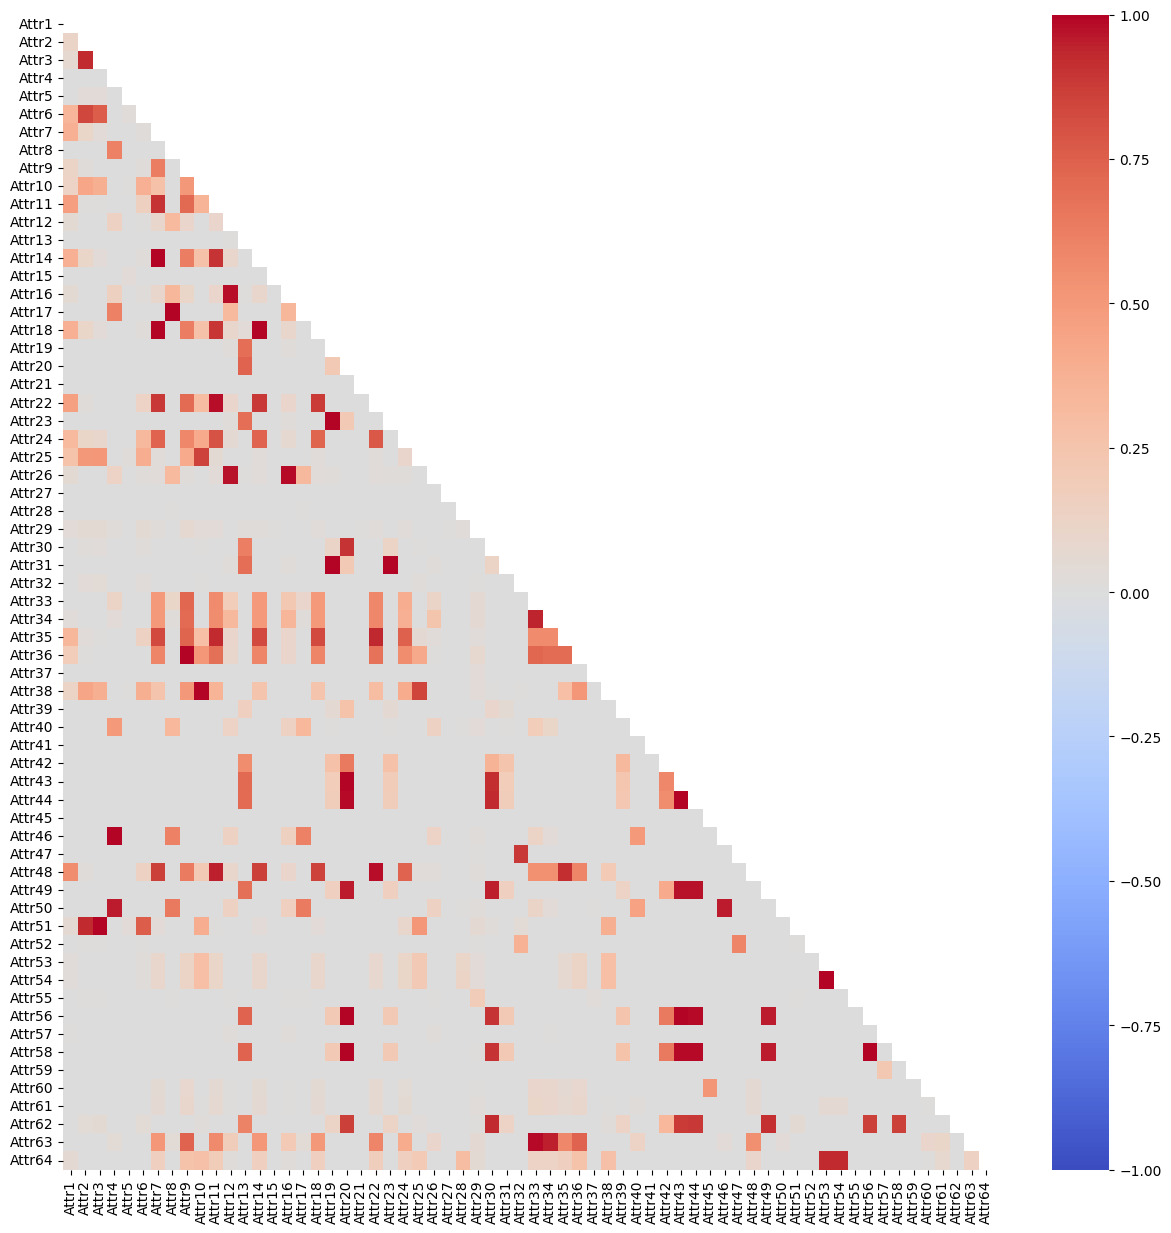

In [20]:
corr_matrix = X.corr()
corr_matrix = corr_matrix.abs()
mask = np.triu( np.ones_like(corr_matrix))

plt.figure(figsize=(15,15))
sns.heatmap(corr_matrix, mask=mask, vmin=-1, vmax=1, cmap="coolwarm", annot=False, fmt=".2f")
plt.show()

In [21]:
corre_thresh= 0.9

corr_matrix = df.corr()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > corre_thresh)]

len(to_drop), to_drop

(26,
 ['Attr11',
  'Attr14',
  'Attr16',
  'Attr17',
  'Attr18',
  'Attr22',
  'Attr23',
  'Attr26',
  'Attr30',
  'Attr31',
  'Attr34',
  'Attr35',
  'Attr36',
  'Attr38',
  'Attr43',
  'Attr44',
  'Attr46',
  'Attr48',
  'Attr50',
  'Attr51',
  'Attr54',
  'Attr56',
  'Attr58',
  'Attr62',
  'Attr63',
  'Attr64'])

In [22]:
X2 = X.drop(columns=to_drop)
X2["y"] = y
print(X2.shape)

X2 = X2.drop_duplicates()
print(X2.shape)

y2 = X2["y"]
X2 = X2.drop(columns=["y"])

(43004, 39)
(42997, 39)


In [23]:
# X2=X
# y2=y

In [24]:
indices = np.arange(X2.shape[0])
train_X, test_X, train_y, test_y, idx_train, idx_test = train_test_split(X2, y2, indices, test_size=0.2, random_state=42)
train_X.shape, test_X.shape, train_y.shape, test_y.shape

((34397, 38), (8600, 38), (34397,), (8600,))

In [25]:
len(idx_train), len(idx_test)

(34397, 8600)

In [26]:
joblib.dump({"idx_train":idx_train, "idx_test":idx_test}, "indexes.pkl")

['indexes.pkl']

In [27]:
Counter(train_y)

Counter({0: 32740, 1: 1657})

In [28]:
# Initialize SMOTE
smote = SMOTE(random_state=42)

train_X2, train_y2 = smote.fit_resample(train_X, train_y)
train_X2.shape, train_y2.shape

((65480, 38), (65480,))

In [29]:
sc = MinMaxScaler()
train_X2 = sc.fit_transform(train_X2)
test_X2 = sc.transform(test_X)

In [30]:
joblib.dump(sc, "min_max_scaler.pkl")

['min_max_scaler.pkl']

In [31]:
Counter(train_y2)

Counter({0: 32740, 1: 32740})

# Modelling

In [32]:
def report_metrics(model, train_X, test_X, train_y, test_y, ):
    pred_train = model.predict(train_X)
    print("Train metrics")
    print(classification_report(train_y, pred_train))

    print("*"*100)

    pred = model.predict(test_X)
    print("Test metrics")
    print(classification_report(test_y, pred))



In [33]:
xgb = XGBClassifier()


param_grid = {
    'n_estimators': [50, 200, 1000],
    'max_depth': [ 7, 20],
}

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    verbose=4,
    n_jobs=-1
)

t1 = time()
grid_search.fit(train_X2, train_y2)
t2=time()

print("Time taken: ", t2-t1)

print("Best Parameters:", grid_search.best_params_)
print("Best CV Score:", grid_search.best_score_)

xgb = grid_search.best_estimator_

# **********************************************************************

# Evaluate on test set
y_pred = xgb.predict(test_X2)

print("Test F1:", f1_score(test_y, y_pred))
print("Test Precision:", recall_score(test_y, y_pred))
print("Test Recall:", precision_score(test_y, y_pred))

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Time taken:  241.9297740459442
Best Parameters: {'max_depth': 7, 'n_estimators': 1000}
Best CV Score: 0.9984533025129004
Test F1: 0.5938303341902313
Test Precision: 0.5422535211267606
Test Recall: 0.65625


In [34]:
joblib.dump(xgb, "xgb_corr.pkl")

['xgb_corr.pkl']

In [35]:
lgb = LGBMClassifier()

param_grid = {
    'n_estimators': [50, 200, 1000],
    'max_depth': [-1, 5,],
}

grid_search = GridSearchCV(
    estimator=lgb,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    verbose=4,
    n_jobs=-1
)

t1 = time()
grid_search.fit(train_X2, train_y2)
t2=time()

print("Time taken: ", t2-t1)

print("Best Parameters:", grid_search.best_params_)
print("Best CV Score:", grid_search.best_score_)

lgb = grid_search.best_estimator_

# **********************************************************************

# Evaluate on test set
y_pred = lgb.predict(test_X2)

print("Test F1:", f1_score(test_y, y_pred))
print("Test Precision:", recall_score(test_y, y_pred))
print("Test Recall:", precision_score(test_y, y_pred))

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[LightGBM] [Info] Number of positive: 32740, number of negative: 32740
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024658 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 65480, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Time taken:  126.56106758117676
Best Parameters: {'max_depth': -1, 'n_estimators': 1000}
Best CV Score: 0.9985230002858582


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Test F1: 0.5945945945945946
Test Precision: 0.5422535211267606
Test Recall: 0.6581196581196581


In [36]:
joblib.dump(lgb, "lgb_corr.pkl")

['lgb_corr.pkl']

In [37]:
cb = CatBoostClassifier()

param_grid = {
    'iterations': [100, 1000],
    'depth': [4, 10],
}

grid_search = GridSearchCV(
    estimator=cb,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    verbose=4,
    n_jobs=-1
)

t1 = time()
grid_search.fit(train_X2, train_y2)
t2=time()

print("Time taken: ", t2-t1)

print("Best Parameters:", grid_search.best_params_)
print("Best CV Score:", grid_search.best_score_)

cb = grid_search.best_estimator_

# **********************************************************************

# Evaluate on test set
y_pred = cb.predict(test_X2)

print("Test F1:", f1_score(test_y, y_pred))
print("Test Precision:", recall_score(test_y, y_pred))
print("Test Recall:", precision_score(test_y, y_pred))

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Learning rate set to 0.061435
0:	learn: 0.6525397	total: 451ms	remaining: 7m 30s
1:	learn: 0.6180972	total: 791ms	remaining: 6m 34s
2:	learn: 0.5883127	total: 972ms	remaining: 5m 22s
3:	learn: 0.5610697	total: 1.17s	remaining: 4m 50s
4:	learn: 0.5384361	total: 1.34s	remaining: 4m 26s
5:	learn: 0.5198659	total: 1.52s	remaining: 4m 12s
6:	learn: 0.5025908	total: 1.7s	remaining: 4m 1s
7:	learn: 0.4903669	total: 1.89s	remaining: 3m 53s
8:	learn: 0.4770558	total: 2.07s	remaining: 3m 48s
9:	learn: 0.4656295	total: 2.28s	remaining: 3m 45s
10:	learn: 0.4546010	total: 2.47s	remaining: 3m 41s
11:	learn: 0.4437227	total: 2.64s	remaining: 3m 37s
12:	learn: 0.4338174	total: 2.82s	remaining: 3m 34s
13:	learn: 0.4263376	total: 3s	remaining: 3m 31s
14:	learn: 0.4184692	total: 3.18s	remaining: 3m 29s
15:	learn: 0.4123341	total: 3.36s	remaining: 3m 26s
16:	learn: 0.4052466	total: 3.54s	remaining: 3m 24s
17:	learn: 0.3999214	total: 3.73s	remaini

In [38]:
joblib.dump(cb, "cb_corr.pkl")

['cb_corr.pkl']

# Data Preparation-2

In [39]:
import gc
gc.collect()

3429

In [40]:
df2 = pd.read_csv("original.csv")

In [41]:
input_columns = list(df2.columns)
input_columns.remove("y")

X = df2[input_columns]
y = df2['y']
y[y!=0]=1           # merge all bankruptcy years in single class

/tmp/ipython-input-2318809585.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[y!=0]=1           # merge all bankruptcy years in single class


In [42]:
# indexes = joblib.load("indexes.pkl")
# idx_train = indexes["idx_train"]
# idx_test = indexes["idx_test"]

In [43]:
train_X = X.iloc[idx_train]
test_X = X.iloc[idx_test]
train_y = y.iloc[idx_train]
test_y = y.iloc[idx_test]

train_X.shape, test_X.shape, train_y.shape, test_y.shape

((34397, 64), (8600, 64), (34397,), (8600,))

In [44]:
# indices = np.arange(X2.shape[0])
# train_X, test_X, train_y, test_y, idx_train, idx_test = train_test_split(X2, y2, indices, test_size=0.2, random_state=42)
# train_X.shape, test_X.shape, train_y.shape, test_y.shape

In [45]:
# Initialize SMOTE
smote = SMOTE(random_state=42)

train_X2, train_y2 = smote.fit_resample(train_X, train_y)
train_X2.shape, train_y2.shape

((65488, 64), (65488,))

In [46]:
sc = MinMaxScaler()
train_X2 = sc.fit_transform(train_X2)
test_X2 = sc.transform(test_X)

In [47]:
joblib.dump(sc, "min_max_scaler_full.pkl")

['min_max_scaler_full.pkl']

# Modelling-2

In [48]:
xgb = XGBClassifier()


param_grid = {
    'n_estimators': [50, 200, 1000],
    'max_depth': [ 7, 20],
}

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    verbose=4,
    n_jobs=-1
)

t1 = time()
grid_search.fit(train_X2, train_y2)
t2=time()

print("Time taken: ", t2-t1)

print("Best Parameters:", grid_search.best_params_)
print("Best CV Score:", grid_search.best_score_)

xgb = grid_search.best_estimator_

# **********************************************************************

# Evaluate on test set
y_pred = xgb.predict(test_X2)
print("Test F1:", f1_score(test_y, y_pred))
print("Test Recall:", recall_score(test_y, y_pred))
print("Test Precision:", precision_score(test_y, y_pred))

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Time taken:  310.7164537906647
Best Parameters: {'max_depth': 7, 'n_estimators': 1000}
Best CV Score: 0.9995501182893226
Test F1: 0.7774869109947644
Test Recall: 0.7021276595744681
Test Precision: 0.8709677419354839


In [49]:
joblib.dump(xgb, "xgb.pkl")

['xgb.pkl']

In [50]:
lgb = LGBMClassifier()

param_grid = {
    'n_estimators': [50, 200, 1000],
    'max_depth': [-1, 5,],
}

grid_search = GridSearchCV(
    estimator=lgb,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    verbose=4,
    n_jobs=-1
)

t1 = time()
grid_search.fit(train_X2, train_y2)
t2=time()

print("Time taken: ", t2-t1)

print("Best Parameters:", grid_search.best_params_)
print("Best CV Score:", grid_search.best_score_)

lgb = grid_search.best_estimator_

# **********************************************************************

# Evaluate on test set
y_pred = lgb.predict(test_X2)
print("Test F1:", f1_score(test_y, y_pred))
print("Test Recall:", recall_score(test_y, y_pred))
print("Test Precision:", precision_score(test_y, y_pred))

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[LightGBM] [Info] Number of positive: 32744, number of negative: 32744
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080288 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16320
[LightGBM] [Info] Number of data points in the train set: 65488, number of used features: 64
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Time taken:  201.63070607185364
Best Parameters: {'max_depth': -1, 'n_estimators': 1000}
Best CV Score: 0.9996459340409208


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Test F1: 0.7783641160949868
Test Recall: 0.6973995271867612
Test Precision: 0.8805970149253731


In [51]:
joblib.dump(lgb, "lgb.pkl")

['lgb.pkl']

In [52]:
cb = CatBoostClassifier()

param_grid = {
    'iterations': [100, 1000],
    'depth': [4, 10],
}

grid_search = GridSearchCV(
    estimator=cb,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    verbose=4,
    n_jobs=-1
)

t1 = time()
grid_search.fit(train_X2, train_y2)
t2=time()

print("Time taken: ", t2-t1)

print("Best Parameters:", grid_search.best_params_)
print("Best CV Score:", grid_search.best_score_)

cb = grid_search.best_estimator_

# **********************************************************************

# Evaluate on test set
y_pred = cb.predict(test_X2)
print("Test F1:", f1_score(test_y, y_pred))
print("Test Recall:", recall_score(test_y, y_pred))
print("Test Precision:", precision_score(test_y, y_pred))

Fitting 3 folds for each of 4 candidates, totalling 12 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Learning rate set to 0.061438
0:	learn: 0.6453116	total: 325ms	remaining: 5m 24s
1:	learn: 0.6020706	total: 602ms	remaining: 5m
2:	learn: 0.5729148	total: 974ms	remaining: 5m 23s
3:	learn: 0.5457783	total: 1.47s	remaining: 6m 5s
4:	learn: 0.5228730	total: 2s	remaining: 6m 38s
5:	learn: 0.5039937	total: 2.55s	remaining: 7m 2s
6:	learn: 0.4852245	total: 3.02s	remaining: 7m 8s
7:	learn: 0.4699590	total: 3.56s	remaining: 7m 21s
8:	learn: 0.4531819	total: 4.03s	remaining: 7m 24s
9:	learn: 0.4403190	total: 4.31s	remaining: 7m 7s
10:	learn: 0.4290960	total: 4.63s	remaining: 6m 56s
11:	learn: 0.4160342	total: 4.91s	remaining: 6m 44s
12:	learn: 0.4056470	total: 5.2s	remaining: 6m 34s
13:	learn: 0.3975210	total: 5.5s	remaining: 6m 27s
14:	learn: 0.3909520	total: 5.77s	remaining: 6m 19s
15:	learn: 0.3809789	total: 6.05s	remaining: 6m 12s
16:	learn: 0.3749113	total: 6.32s	remaining: 6m 5s
17:	learn: 0.3675168	total: 6.65s	remaining: 6m 2s
18:	learn: 0.3627484	total: 7.11s	remaining: 6m 6s
19:	lear

In [53]:
joblib.dump(cb, "cb.pkl")

['cb.pkl']

# Test Results

<table>


<tr>
<th>Model</th>
<th>Precision</th>
<th>Recall</th>
<th>F1 score</th>
</tr>

<tr>
<td>XGBoost</td>
<td>0.871</td>
<td>0.702</td>
<td>0.777</td>
</tr>

<tr>
<td>LightGBM</td>
<td>0.880</td>
<td>0.697</td>
<td>0.778</td>
</tr>

<tr>
<td>CatBoost</td>
<td>0.829</td>
<td>0.680</td>
<td>0.748</td>
</tr>





</table>